In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
def extract_data(league: str) -> pd.DataFrame:
    '''
    This function generates the data for historical backtest.
    To deal with historical matches per team we need to have the data oriented as a two row per match.
    If we kept only the original table coming from Football Data, using pd.Rolling function would only 
    extract the history from the team when the team plays at Home.
    As we want to have the historical data regarding matches where the team plays home and away we have to transform the 
    original csv file a bit.
    '''
    #Initialize seasons to loop
    season_loop = ['0809','0910','1011','1112','1213','1314','1415','1516','1617','1718','1819']
    #Dictionary used to store dataframes for each season
    dataframes = {}
    #Execution manager variable
    i=0
    for season in season_loop:
        #Read season data for the league - use football-data URL
        dataframes[season] = pd.read_csv("http://www.football-data.co.uk/mmz4281/"+season+"/"+league+".csv")
        #To use team history we will have to replicate the away vision for each team
        #The data coming from football data is one line per match and we want to turn it into a two line per match
        #A vision for the away team and a vision for the home (the original one) 
        away_team = dataframes[season].copy()
        #Switch columns Home Team / Away Team and FTHG / FTAG 
        away_team = away_team.loc[:,['Date','AwayTeam','HomeTeam','FTAG','FTHG','B365A']]
        away_team.columns = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','OddsWin']
        #Explicity set this vision as Away vision
        away_team['Field'] = 'Away'
        #Get similar data for the home team vision
        home_team = pd.DataFrame(dataframes[season].
                                 loc[:,['Date','HomeTeam','AwayTeam','FTHG','FTAG','B365H']])
        #Rename columns to match away team vision
        home_team.columns = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','OddsWin']
        #Explicity set this vision as Away vision
        home_team['Field'] = 'Home'
        #Append both visions
        home_away = home_team.append(away_team)
        #Rename Home Team and Away team to avoid confusion - now the Team1 can be playing Home or Away according to Field
        home_away.columns = ['Date','Team1','Team2','FTHG','FTAG','OddsWin','Field']
        #Convert date object to date
        home_away['Date'] = pd.to_datetime(home_away['Date'], dayfirst=True)
        #Sort by date
        home_away = home_away.sort_values('Date')
        #Count the number of matches per season per Team
        home_away['num_matches'] = home_away.groupby('Team1').cumcount()
        #Set season
        home_away['Season'] = season
        #If this is the first execution - set master_table as home away, else append to existing one
        if i==0: master_table = home_away
        else: master_table = master_table.append(home_away)
        i=+1
    master_table = master_table.dropna()
    master_table = master_table.sort_values(['Team1','Date'])
    #Reset index - We want a new index sorted by Team1 and Data to later use in rolling means
    master_table.reset_index(inplace=True, drop=True)
    return master_table 

In [3]:
#Generate Master table according to Division - Check football-data for available leagues - Example used is for English Premier League
master_table = extract_data('E0')

In [6]:
#Create empty dictionaries for two visions - transitioning matches for last season and keeping only results from current season
accuracy_of_logistic = {}
accuracy_of_logistic_with_transition = {}

def run_results(historical_matches: int, transition_last_season: int):
    table = master_table.copy()
    #Use rolling to sum last x goals per match. As the rolling sums the current row you want to subtract the current goals scored to disable data leakage to the game Ranking
    #Do the same for Goals Scored and Goals Conceded
    table['Cumulative_Scored_Matches'] = (table.groupby('Team1')['FTHG'].
                                          apply(lambda x: x.rolling(window=historical_matches+1).sum())
                                          - table['FTHG'])
    table['Cumulative_Conceded_Matches'] = (table.groupby('Team1')['FTAG'].
                                            apply(lambda x: x.rolling(window=historical_matches+1).sum())
                                            - table['FTAG'])
    #The Home Team strength is equal to the Goals scored by the home team - the goals conceded
    table['HomeTeamRanking'] = table.Cumulative_Scored_Matches-table.Cumulative_Conceded_Matches
    
    #Same Rationale for the Away Team
    away_team_version = master_table.copy()
    away_team_version = away_team_version.sort_values(['Team2','Date'])
    away_team_version.reset_index(inplace=True, drop=True)
    
    away_team_version['Cumulative_Scored_Matches'] = (away_team_version.groupby('Team2')['FTAG'].
                                                      apply(lambda x: x.rolling(window=historical_matches).sum()) 
                                                      - away_team_version['FTAG'])
    away_team_version['Cumulative_Conceded_Matches'] = (away_team_version.groupby('Team2')['FTHG'].
                                                        apply(lambda x: x.rolling(window=historical_matches).
                                                              sum()) - away_team_version['FTHG'])
    away_team_version['AwayTeamRanking'] = away_team_version.Cumulative_Scored_Matches-away_team_version.Cumulative_Conceded_Matches
    
    #Merge by the first team and Date (no team can play two matches on the same day for the same league) 
    table = table.merge(away_team_version.loc[:,['Date','Team1','AwayTeamRanking']], on=['Date','Team1'])
    #Calculate game Ranking
    table['GameRanking'] = table.HomeTeamRanking - table.AwayTeamRanking
    #Check if the Home team won the Game and select only the "Home" team vision
    table['Home_Win'] = np.where(table.FTHG > table.FTAG, 1, 0)
    table = table.loc[table.Field == 'Home']
    
    #If table is transitioning from last season we will only have to drop the rows with no sufficient history
    #If we are not transitioning from last season then we want to only consider the games where the game count per season is
    #higher than the historical matches parameters
    if transition_last_season: table = table.dropna()
    else: table = table.loc[table.num_matches >= historical_matches]
    
    #sort table by game ranking
    table.sort_values('GameRanking', ascending=False)
    
    #Calculate the percentage of Home wins per ranking and scatter plot it
    pct_game_ranking = (pd.DataFrame(table.groupby('GameRanking')['Home_Win'].sum()/
                                     table.groupby('GameRanking').count().iloc[:,0]))
    
    plt.scatter(pct_game_ranking.index, pct_game_ranking)
    
    #Create np arrays with Game Ranking (Feature) and Home_Win (target)
    X = np.array(table.GameRanking)
    y = np.array(table.Home_Win)
    
    #Fit Logistic Regression - consciously not using train-test-partition to learn the parameters
    logistic = LogisticRegression(solver='lbfgs')
    logistic.fit(X.reshape(-1,1),y.reshape(-1,1))
    
    #Obtain prediction
    y_pred = logistic.predict(X.reshape(-1,1))
    table['predictions'] = logistic.predict_proba(X.reshape(-1,1))[:,1]
    
    #Update dictionaries according to the transitioning matches rule
    if transition_last_season: accuracy_of_logistic_with_transition[historical_matches] = accuracy_score(y,y_pred)
    else: accuracy_of_logistic[historical_matches] = accuracy_score(y,y_pred)

    return table, logistic

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

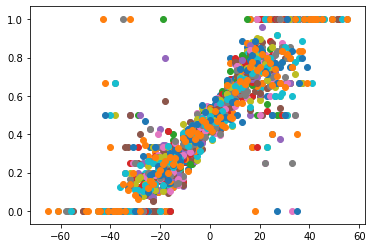

In [7]:
#Run a loop using different historical number of matches to calculate game ranking for transitioning and no transitioning
for i in np.arange(4,15):
    run_results(i,0)
    run_results(i,1)

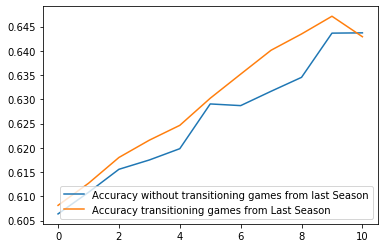

In [8]:
#Plot differences in accuracy using transitioning matches and no transitioning
plt.plot(list(accuracy_of_logistic.values()))
plt.plot(list(accuracy_of_logistic_with_transition.values()))
plt.legend(['Accuracy without transitioning games from last Season','Accuracy transitioning games from Last Season'], loc = 'best')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


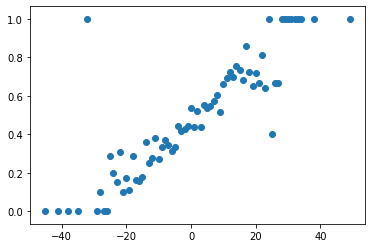

In [9]:
#We chose 9 historical matches with transitioning for final study
results_9, obj = run_results(9,1)

In [10]:
#Check full table 
results_9.head(10)

,Date,Team1,Team2,FTHG,FTAG,OddsWin,Field,num_matches,Season,Cumulative_Scored_Matches,Cumulative_Conceded_Matches,HomeTeamRanking,AwayTeamRanking,GameRanking,Home_Win,predictions
9,2008-10-29,Arsenal,Tottenham,4.0,4.0,1.44,Home,9,0809,18.0,6.0,12.0,-4.0,16.0,0,0.719551
11,2008-11-08,Arsenal,Man United,2.0,1.0,3.25,Home,11,0809,22.0,11.0,11.0,10.0,1.0,1,0.480392
12,2008-11-15,Arsenal,Aston Villa,0.0,2.0,1.50,Home,12,0809,21.0,12.0,9.0,2.0,7.0,0,0.581713
15,2008-12-06,Arsenal,Wigan,1.0,0.0,1.33,Home,15,0809,15.0,15.0,0.0,-4.0,4.0,1,0.531376
17,2008-12-21,Arsenal,Liverpool,1.0,1.0,2.40,Home,17,0809,13.0,14.0,-1.0,7.0,-8.0,0,0.333833
19,2008-12-28,Arsenal,Portsmouth,1.0,0.0,1.40,Home,19,0809,10.0,13.0,-3.0,-5.0,2.0,1,0.497394
20,2009-01-10,Arsenal,Bolton,1.0,0.0,1.36,Home,20,0809,10.0,11.0,-1.0,-4.0,3.0,1,0.514401
23,2009-01-31,Arsenal,West Ham,0.0,0.0,1.50,Home,23,0809,13.0,7.0,6.0,5.0,1.0,0,0.480392
25,2009-02-21,Arsenal,Sunderland,0.0,0.0,1.40,Home,25,0809,10.0,6.0,4.0,2.0,2.0,0,0.497394
26,2009-02-28,Arsenal,Fulham,0.0,0.0,1.40,Home,26,0809,9.0,5.0,4.0,-2.0,6.0,0,0.565070


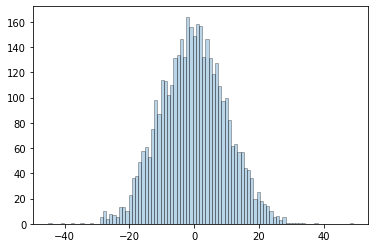

In [11]:
#Plot Histogram per Game Ranking - Approximately a Normal distribution
kwargs = dict(alpha=0.3, bins=95, ec="k")
plt.hist(results_9.GameRanking, **kwargs)
plt.savefig('HistogramGameRankings.jpeg')

In [12]:
#Check mean of Game Ranking
results_9.GameRanking.mean()

-0.36196009093205356

In [13]:
#Check percentage of Home Wins per game ranking
results_9.sort_values('GameRanking', ascending=False)
pct_game_ranking = pd.DataFrame(results_9.groupby('GameRanking')['Home_Win'].sum()/results_9.groupby('GameRanking').count().iloc[:,0])

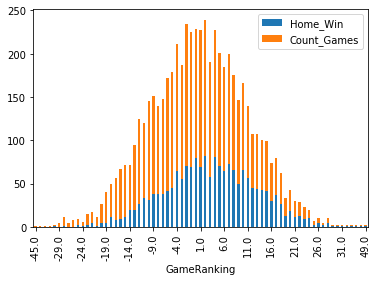

In [14]:
#Plot Game ranking and Total sum of Wins
plott = pd.DataFrame(results_9.groupby('GameRanking')['Home_Win'].sum())
plott['Count_Games'] = pd.DataFrame(results_9.groupby('GameRanking').count()).iloc[:,0]

n = 5 
ax = plott.plot.bar(stacked=True)
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])
plt.savefig('HomeWinsCountGames.jpeg')

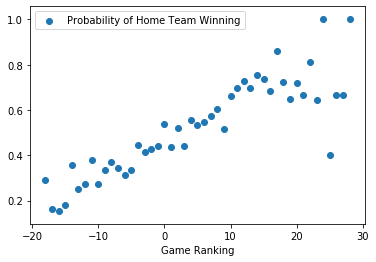

In [15]:
#Plot the probability of the Home Team Winning - Only check intermediate ratings to avoid outliers
ax = plt.scatter(pct_game_ranking[-18:28].index, pct_game_ranking[-18:28])
plt.legend(['Probability of Home Team Winning'])
plt.xlabel('Game Ranking')
plt.savefig('GameRanking.jpeg')

In [16]:
#Print intercept and coefficient from regresion
print(obj.intercept_ ,obj.coef_)

[-0.14651989] [[0.0680472]]


In [17]:
#Calculate the difference between the bookmaker odds and our calculated Odds
results_9['OddDif'] = results_9.OddsWin- 1/results_9.predictions

In [18]:
#Sort values by difference in odds
results_9.sort_values('OddDif',ascending=False)

,Date,Team1,Team2,FTHG,FTAG,OddsWin,Field,num_matches,Season,Cumulative_Scored_Matches,Cumulative_Conceded_Matches,HomeTeamRanking,AwayTeamRanking,GameRanking,Home_Win,predictions,OddDif
1555,2019-04-28,Burnley,Man City,0.0,1.0,23.00,Home,35,1819,15.0,15.0,0.0,13.0,-13.0,0,0.262864,19.195757
3024,2019-01-20,Huddersfield,Man City,0.0,3.0,21.00,Home,22,1819,5.0,15.0,-10.0,5.0,-15.0,0,0.237356,16.786927
5077,2019-01-29,Newcastle,Man City,2.0,1.0,19.00,Home,23,1819,8.0,12.0,-4.0,7.0,-11.0,1,0.290071,15.552569
1601,2018-09-22,Cardiff,Man City,0.0,5.0,23.00,Home,5,1819,5.0,19.0,-14.0,14.0,-28.0,0,0.113866,14.217782
2957,2019-03-30,Fulham,Man City,0.0,2.0,21.00,Home,31,1819,9.0,21.0,-12.0,16.0,-28.0,0,0.113866,12.217782
1367,2019-05-12,Brighton,Man City,1.0,4.0,19.00,Home,37,1819,4.0,15.0,-11.0,13.0,-24.0,0,0.144346,12.072203
1630,2019-04-21,Cardiff,Liverpool,0.0,2.0,17.00,Home,34,1819,8.0,17.0,-9.0,13.0,-22.0,0,0.161981,10.826454
6704,2017-12-13,Swansea,Man City,0.0,4.0,15.00,Home,16,1718,6.0,10.0,-4.0,12.0,-16.0,0,0.225260,10.560676
6109,2018-03-12,Stoke,Man City,0.0,2.0,15.00,Home,29,1718,5.0,13.0,-8.0,14.0,-22.0,0,0.161981,8.826454
1534,2018-12-05,Burnley,Liverpool,1.0,3.0,14.00,Home,14,1819,10.0,19.0,-9.0,10.0,-19.0,0,0.191636,8.781766


In [19]:
#Subset only the matches where the OddDif is between 1.51 and 2.49
odd_dif_2 = results_9.loc[round(results_9.OddDif,0) == 2]

In [20]:
#Calculate profit per bet
odd_dif_2['Profit'] = np.where(odd_dif_2.Home_Win == 1, odd_dif_2.OddsWin*1-1, -1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
#Average return
odd_dif_2['Profit'].sum()/len(odd_dif_2)

0.19008771929824564

In [22]:
#Sum returns by season
Season_Return = pd.DataFrame(odd_dif_2.groupby('Season')['Profit'].sum()/odd_dif_2.groupby('Season').count().iloc[:,0])
Season_Return.columns = ['Return']

In [23]:
#Separate positive and negative returns
pos_returns = Season_Return.loc[Season_Return.Return > 0]
neg_returns = Season_Return.loc[Season_Return.Return <= 0]

pos_returns.index = pos_returns.index.astype(int)
neg_returns.index = neg_returns.index.astype(int)

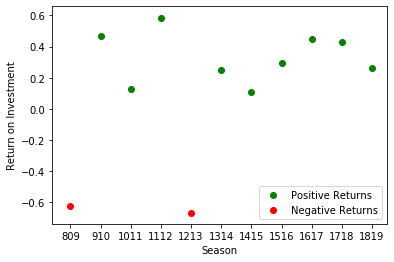

In [24]:
#Scatter Plot the positive and negative cases
fig, ax = plt.subplots()

plt.scatter(pos_returns.index,pos_returns, color='green')
plt.scatter(neg_returns.index,neg_returns, color='red')

#plt.xticks(np.arange(0, len(Season_Return), 1.0))

ax.set_xticks([809,910,1011,1112,1213,1314,1415,1516,1617,1718,1819])
plt.xlabel('Season')
plt.ylabel('Return on Investment')
plt.legend(['Positive Returns','Negative Returns'])
plt.savefig('Eredivisie League Returns.jpeg')
#ax.set_xticklabels(season_order)